In [50]:
import pandas as pd
from sklearn import linear_model
import csv
import matplotlib.pyplot as plt
from eyeInfo import EyeInfo
import numpy as np
import seaborn as sns

In [51]:
# coloque o prefixo do nome na variavel prefix para analisar
prefix = ''
# quantidade de dados por ponto de calibração
subset_size = 100
# divide os clusters em cores
is_subset = True
# determina se o grafico deve ou nao ficar travado nas dimensoes upper_lim_x e upper_lim_y
lock_plot = False
# determina se o grafico vai mostrar ou nao a distancia do centroide
display_centroid = True

display_train_data = True
display_predict_data = True
display_cost = True
display_prediction = True
display_label = True

In [52]:
output = './csv/output/output.csv'
output_right = './csv/output/outright.csv'
output_left = './csv/output/outleft.csv'
train_input = f'./csv/data/{prefix}_fixed_train_data.csv'
predict_input = f'./csv/data/{prefix}_predict_train_data.csv'

fieldnames = ['screen_x', 'screen_y','left_iris_x','left_iris_y','right_iris_x','right_iris_y']
fieldnames_left = ['screen_x', 'screen_y', 'left_iris_x','left_iris_y']
fieldnames_rigth = ['screen_x', 'screen_y', 'right_iris_x','right_iris_y']

full_palette = {
    'calib_df': 'black',
    'first': 'blue',
    'second': 'red',
    'third': 'green',
    'fourth': 'yellow',
    'fifth':'lightgreen',
    'sixth': 'purple',
    'seventh': 'orange',
    'eighth': 'pink',
    'ninth': 'turquoise'
}

full_legend_dict = {
    full_palette['first']: 'Cluster 1',
    full_palette['second']: 'Cluster 2',
    full_palette['third']: 'Cluster 3',
    full_palette['fourth']: 'Cluster 4',
    full_palette['fifth']: 'Cluster 5',
    full_palette['sixth']: 'Cluster 6',
    full_palette['seventh']: 'Cluster 7',
    full_palette['eighth']: 'Cluster 8',
    full_palette['ninth']: 'Cluster 9',
}

In [53]:
def train_to_validate_calib(output, fieldnames, isLeft, isRight):

    dataset_train_path = train_input
    dataset_predict_path = predict_input
    data = pd.read_csv(dataset_train_path)
    if isLeft:
        X = data[['left_iris_x', 'left_iris_y']]
        y = data[['point_x', 'point_y']]
    elif isRight:
        X = data[['right_iris_x', 'right_iris_y']]
        y = data[['point_x', 'point_y']]
    else:
        X = data[['left_iris_x', 'left_iris_y', 'right_iris_x', 'right_iris_y']]
        y = data[['point_x', 'point_y']]

    model = linear_model.LinearRegression()
    model.fit(X, y)
    dados_teste = pd.read_csv(dataset_predict_path)
    if isLeft:
        dados_teste.drop(['right_iris_x', 'right_iris_y'],
                         axis=1, inplace=True)
        eye_positions = dados_teste[['left_iris_x', 'left_iris_y']].values
    elif isRight:
        dados_teste.drop(['left_iris_x', 'left_iris_y'], axis=1, inplace=True)
        eye_positions = dados_teste[['right_iris_x', 'right_iris_y']].values
    else:
        eye_positions = dados_teste[[
            'left_iris_x', 'left_iris_y', 'right_iris_x', 'right_iris_y']].values

    previsoes = model.predict(dados_teste)
    combined_predictions = np.concatenate((previsoes, eye_positions), axis=1)

    with open(output, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        writer.writeheader()

        for row in combined_predictions:
            if isLeft:
                writer.writerow(
                    {'screen_x': row[0], 'screen_y': row[1], 'left_iris_x': row[2], 'left_iris_y': row[3]})
            elif isRight:
                writer.writerow(
                    {'screen_x': row[0], 'screen_y': row[1], 'right_iris_x': row[2], 'right_iris_y': row[3]})
            else:
                writer.writerow({'screen_x': row[0], 'screen_y': row[1], 'left_iris_x': row[2],
                                'left_iris_y': row[3], 'right_iris_x': row[4], 'right_iris_y': row[5]})


def extract_calib(csv_path, entries):
    df = pd.read_csv(csv_path)

    unique_points = []
    seen = set()
    change = 0

    for index, row in df.iterrows():
        point_x, point_y = row['point_x'], row['point_y']
        if (point_x, point_y) not in seen:
            change = change+1
            unique_points.append({'x': point_x, 'y': point_y, 'order': change})
            seen.add((point_x, point_y))
        if len(unique_points) == entries:
            break

    return unique_points


def extract_hw(csv_path):
    df = pd.read_csv(csv_path)
    interest = df.iloc[0]
    return interest['screen_height'], interest['screen_width']

In [54]:
train_to_validate_calib(output, fieldnames, isLeft=False, isRight=False)

In [55]:
calib_points = extract_calib(train_input, subset_size)
h, w = extract_hw(train_input)
legend_dict = {key: full_legend_dict[key] for key in list(full_legend_dict)[
    :len(calib_points)]}
eye = EyeInfo(calib_points=calib_points, dataset=output,
              screen_height=h, screen_width=w)
eye.init_eye()

In [56]:
def full_plot(df, eyes_only):

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    eye.plot(datasets=[df, df], keys_x=['left_iris_x', 'right_iris_x'],
             keys_y=['left_iris_y', 'right_iris_y'], is_subset=is_subset, subset_size=subset_size,
             lock_plot=lock_plot, eyes_only=eyes_only, ax=axs[0], display_centroid=display_centroid)
    axs[0].set_title("Both Eyes - Fixed Train")
    eye.plot(datasets=[df], keys_x=['left_iris_x'], keys_y=['left_iris_y'],
             is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_train_data, ax=axs[1], display_centroid=display_centroid)
    axs[1].set_title("Right Eye - Fixed Train")
    eye.plot(datasets=[df], keys_x=['right_iris_x'], keys_y=['right_iris_y'],
             is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_train_data, ax=axs[2], display_centroid=display_centroid)
    axs[2].set_title("Left Eye - Fixed Train")
    if display_label:
        for color, label in legend_dict.items():
            plt.scatter([], [], c=color, label=label)
            plt.legend()
    plt.tight_layout()
    plt.show()

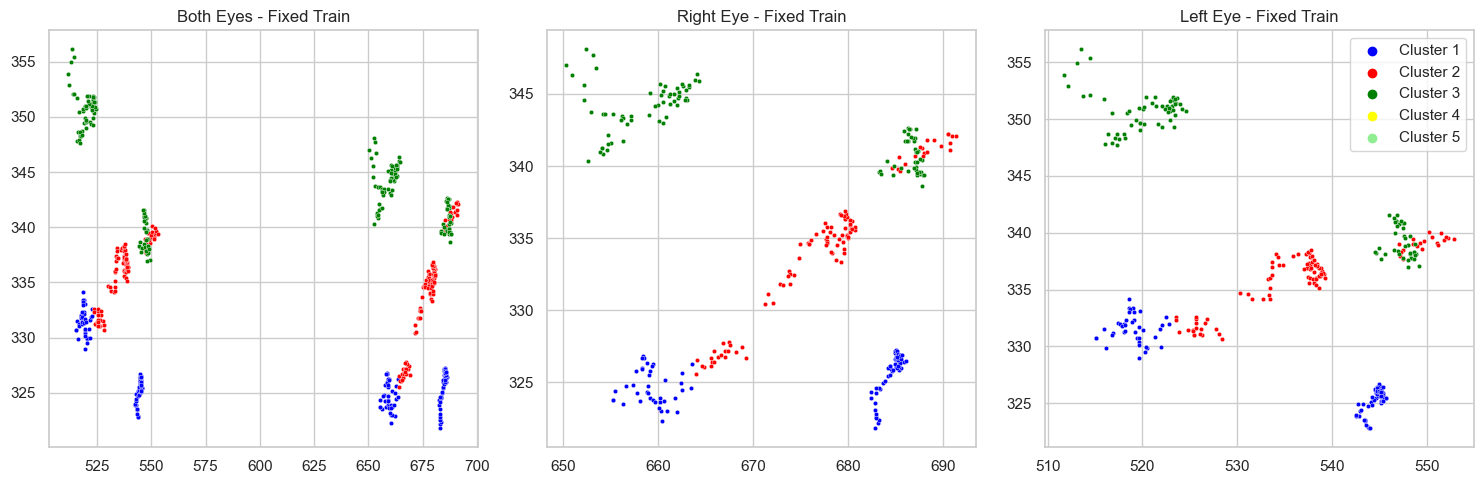

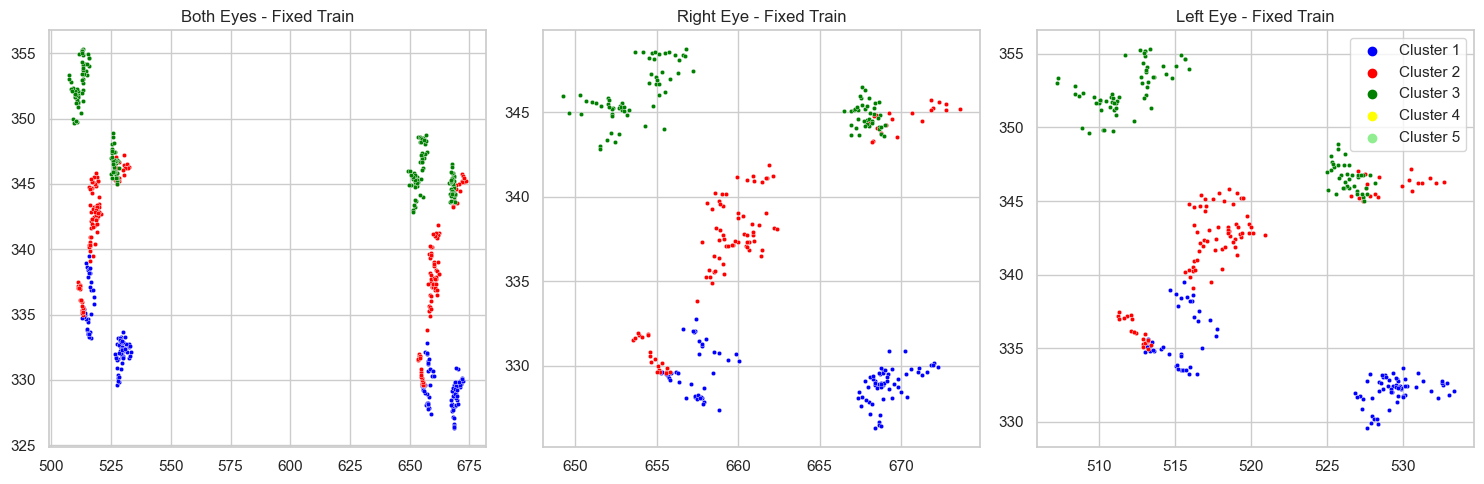

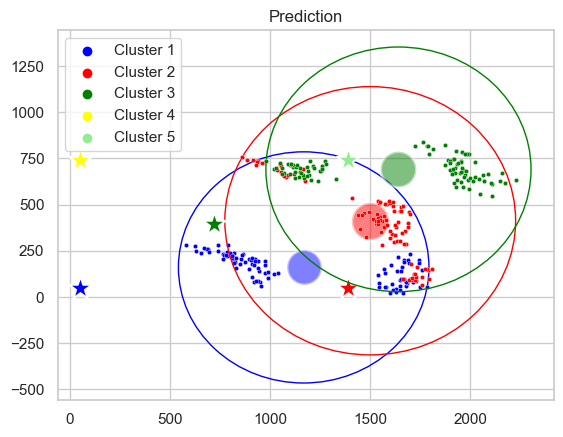

In [57]:
prediction_df = eye.prediction_df
fixed_train_df = pd.read_csv(train_input)
predict_train_df = pd.read_csv(predict_input)
if display_train_data:
    full_plot(fixed_train_df, True)
if display_predict_data:
    full_plot(predict_train_df, True)
if display_prediction:
    fig, ax = plt.subplots(1, 1)
    eye.plot(datasets=[prediction_df], keys_x=['screen_x'], keys_y=['screen_y'],
             is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot,
             eyes_only=not display_prediction, ax=ax, display_centroid=display_centroid)
    ax.set_title("Prediction")
    if display_label:
        for color, label in legend_dict.items():
            plt.scatter([], [], c=color, label=label)
            plt.legend()
    plt.show()